In [1]:
import torch
import transformers

from tqdm import tqdm
import numpy as np

In [3]:
import os

def load_txt_files_to_dict(directory, filetype=".txt"):
    text_dict = {}
    for filename in os.listdir(directory):
        if filename.endswith(filetype):
            file_path = os.path.join(directory, filename)
            with open(file_path, "r", encoding="utf-8") as file:
                text = file.read()
                text_dict[os.path.splitext(filename)[0]] = text.split("\n")
    return text_dict

def load_txt_files_to_dict__flores(directory):
    text_dict = {}
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        with open(file_path, "r", encoding="utf-8") as file:
            text = file.read()
            # Flores' files with text do not have the extension. The language is indicated after the dot symbol
            text_dict[os.path.splitext(filename)[1][1:]] = text.split("\n")
    return text_dict

In [4]:
data_dir = "floresp-v2.0-rc.3/dev"
dataset_texts = load_txt_files_to_dict__flores(data_dir)

In [5]:
#sorted(list(dataset_texts.keys()))

In [5]:
languages_of_interest =  ['arb_Arab', 'zho_Hant', 'nld_Latn', 'fra_Latn',
                          'deu_Latn', 'ita_Latn', 'rus_Cyrl', 
                          'spa_Latn', 'ukr_Cyrl', "eng_Latn"]
lang_names = languages_of_interest

In [6]:
# Delete language keys in the dataset dict that are not present in the App. a at https://huggingface.co/microsoft/Phi-3.5-mini-instruct#appendix-a

iter_keys = list(dataset_texts.keys())
for key in iter_keys:
    if key not in languages_of_interest:
        del dataset_texts[key]

In [7]:
[(k, len(v)) for k, v in dataset_texts.items()]

[('ukr_Cyrl', 998),
 ('rus_Cyrl', 998),
 ('spa_Latn', 998),
 ('eng_Latn', 998),
 ('ita_Latn', 998),
 ('nld_Latn', 998),
 ('fra_Latn', 998),
 ('deu_Latn', 998),
 ('arb_Arab', 998)]

In [8]:
from transformers.trainer_pt_utils import LengthGroupedSampler
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


def data_collator(examples, padding_value=0, max_length=2048):
    def trim_and_pad(seq, batch_first, padding_value):
        return pad_sequence([s[:max_length] for s in seq], batch_first=True, padding_value=padding_value)

    padding_value = tokenizer.pad_token_id or padding_value

    input_ids = trim_and_pad(
        [torch.tensor(example["input_ids"], dtype=torch.int32) for example in examples],
        batch_first=True,
        padding_value=padding_value,
    )

    tokenized_sentences = input_ids[::]

    targets = tokenized_sentences[:, 1:].long()
    input_ids = tokenized_sentences[:, :-1].long()

    corpus_ids = torch.stack([torch.tensor(example["corpus_id"], dtype=torch.int32) for example in examples])

    #targets=targets,

    return dict(input_ids=input_ids, corpus_ids=corpus_ids, targets=targets, attention_mask=input_ids.ne(padding_value))

In [9]:
def get_first_level_layer_names(model):
    first_level_layers = ["embed_tokens"]
    for name, module in model.named_modules():
        if name.count(".") == 2:
            first_level_layers.append(name.split(".", 1)[1])
    return first_level_layers

In [10]:
def wrap_outputs_to_dict(outputs, batch, layer_names):
    # Length of non-pad elems to not save embeddings for padding tokens
    batch_lengths = batch["attention_mask"].sum(1)

    listed_hidden_states = []
    outputs.hidden_states = outputs.hidden_states
    for hidden_state_tensor in outputs.hidden_states:
        listed_hidden_state_tensor = {
            batch["corpus_ids"][i]: hidden_state_tensor[i, : batch_lengths[i]] for i in range(len(hidden_state_tensor))
        }
        listed_hidden_states.append(listed_hidden_state_tensor)
    hidden_state_tensors = {}
    for i, hidden_state in enumerate(listed_hidden_states):
        for idx, tensor in hidden_state.items():
            hidden_state_tensors["-".join([str(idx.numpy()), layer_names[i]])] = tensor.detach().cpu()
    return hidden_state_tensors

In [11]:
from safetensors import safe_open
from safetensors.torch import save_file
import gc


def process_and_save_embeddings(model, model_id, dataloader, current_lang):
    model_dir = 'rand-'+model_id.split("/")[1]
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    filename = f"{model_dir}/{current_lang}.st"
    if f"{current_lang}.st" in os.listdir(model_dir):
        print(current_lang, 'done')
        return None
        
    torch.cuda.empty_cache()
    layer_names = get_first_level_layer_names(model)
    keys = ["attention_mask", "corpus_ids"]

    hidden_state_tensors = {}
    for batch in tqdm(dataloader, leave=True):
        info_data = {k: batch[k] for k in keys}

        input_ids = batch["input_ids"].to(device=device)
        attention_mask = batch["attention_mask"].to(device=device)

        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

        # in place 'or' operation
        hidden_state_tensors |= wrap_outputs_to_dict(output, info_data, layer_names)


    # This is going to be num_layers * batch_size
    print(current_lang, len(hidden_state_tensors))

    filename = f"{model_dir}/{current_lang}.st"
    save_file(hidden_state_tensors, filename)

    for _ in range(2):
        torch.cuda.empty_cache()
        gc.collect()

    return hidden_state_tensors

In [12]:
dataset_texts.keys()

dict_keys(['ukr_Cyrl', 'rus_Cyrl', 'spa_Latn', 'eng_Latn', 'ita_Latn', 'nld_Latn', 'fra_Latn', 'deu_Latn', 'arb_Arab'])

In [17]:
#for name, param in model.named_parameters():
#    print(name)

In [13]:
from transformers import AutoModelForCausalLM, AutoTokenizer

DEVICE = 'cuda:2'
device = DEVICE
model_names = [
    # "ai-forever/mGPT",
    # "gradientai/Llama-3-8B-Instruct-Gradient-1048k",
    # "mistralai/Mistral-7B-Instruct-v0.3",
    # Proj 34
    "Qwen/Qwen2-0.5B-Instruct"
    #"microsoft/Phi-3.5-mini-instruct"
]

for model_id in model_names:
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    # tokenized_texts = {name: tokenizer(text) for name, text in dataset_texts.items()}
    tokenized_texts = {name: tokenizer(text) for name, text in dataset_texts.items()} #dataset_texts

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        # attn_implementation="flash_attention_2", # not for V100
        use_cache=False,
        torch_dtype=torch.bfloat16,
        device_map=DEVICE,
    )

    model_dir = model_id.split("/")[1]
    batch_size = 16

    for current_lang in (tokenized_texts.keys()):
        filename = f"{model_dir}/{current_lang}.st"

        # if os.path.exists(filename):
        #     continue

        current_dataset = [
            {"input_ids": input_ids, "corpus_id": i}
            for i, input_ids in enumerate(tokenized_texts[current_lang]["input_ids"])
        ]

        current_sampler = LengthGroupedSampler(
            dataset=current_dataset,
            batch_size=batch_size,
        )

        current_loader = DataLoader(
            current_dataset,
            collate_fn=data_collator,
            sampler=current_sampler,
            batch_size=batch_size,
            shuffle=False,
        )

        # hidden_state_tensors = process_and_save_embeddings(model, model_id, current_loader, current_lang)

In [14]:
next(iter(current_loader))

{'input_ids': tensor([[138023,  50243,  32790,  ...,   5703, 125110, 123938],
         [138023,  27846,  57859,  ..., 151643, 151643, 151643],
         [138735,  39434, 124861,  ..., 151643, 151643, 151643],
         ...,
         [124363, 125007,  73771,  ..., 151643, 151643, 151643],
         [ 23224, 124523, 124009,  ..., 151643, 151643, 151643],
         [  8532, 132554,  85153,  ..., 151643, 151643, 151643]]),
 'corpus_ids': tensor([125,  73, 110, 165, 547, 845,  26, 840, 502, 107, 810, 240, 124, 718,
          67, 451], dtype=torch.int32),
 'targets': tensor([[ 50243,  32790,  69682,  ..., 125110, 123938,     13],
         [ 27846,  57859, 124511,  ..., 151643, 151643, 151643],
         [ 39434, 124861,  59397,  ..., 151643, 151643, 151643],
         ...,
         [125007,  73771,  44330,  ..., 151643, 151643, 151643],
         [124523, 124009, 138829,  ..., 151643, 151643, 151643],
         [132554,  85153, 124983,  ..., 151643, 151643, 151643]]),
 'attention_mask': tensor([[ Tr

# Calculating BPC

In [15]:
import torch
from torch.utils.data import DataLoader
import argparse
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
)
#from packed_dataset import EvalDataset
import numpy as np
from tqdm import tqdm

def cross_entropy(
    logits, targets, attention_mask: torch.Tensor = None
):

    logits = logits.reshape(-1, logits.size(-1))
    targets = targets.reshape(-1)
    if attention_mask is not None:
        attention_mask = attention_mask.reshape(-1)
        targets = targets.masked_fill(~attention_mask, -1)

    return torch.nn.functional.cross_entropy(logits, targets, ignore_index=-1, reduction='sum')


In [16]:
@torch.no_grad()
def validate(model, val_dataloader: DataLoader, device):
    model.eval()
    losses = []
    total_characters = 0
    
    for val_data in tqdm(val_dataloader):
        #input_ids = val_data[:, 0: args.block_size].contiguous().to(device)
        #targets = val_data[:, 1: args.block_size + 1].contiguous().long().to(device)

        input_ids = val_data['input_ids'].to(device)
        targets = val_data['targets'].to(device)

       #attention_mask = attention_mask[:, 1: args.block_size + 1].contiguous().to(device)
        attention_mask = val_data['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = cross_entropy(logits, targets, attention_mask=attention_mask)
        loss = loss.cpu().item()
        losses.append(loss)

        total_characters += (targets != -1).sum().item()
        #print("%.8f" % loss)

    out = np.array(losses).sum()

    total_bits = out  * np.log2(np.e)
    return out, total_bits, total_characters

In [17]:
current_loader

In [18]:
from transformers import AutoModelForCausalLM, AutoTokenizer

def load_lang(dataset_texts):

    DEVICE = 'cuda:2'
    device = DEVICE
    model_names = [
        # "ai-forever/mGPT",
        # "gradientai/Llama-3-8B-Instruct-Gradient-1048k",
        # "mistralai/Mistral-7B-Instruct-v0.3",
        # Proj 34
        "Qwen/Qwen2-0.5B-Instruct"
        #"microsoft/Phi-3.5-mini-instruct"
    ]

    for model_id in model_names:
        tokenizer = AutoTokenizer.from_pretrained(model_id)
        # tokenized_texts = {name: tokenizer(text) for name, text in dataset_texts.items()}
        tokenized_texts = {name: tokenizer(text) for name, text in dataset_texts.items()} #dataset_texts

        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            # attn_implementation="flash_attention_2", # not for V100
            use_cache=False,
            torch_dtype=torch.bfloat16,
            device_map=DEVICE,
        )

        model_dir = model_id.split("/")[1]
        batch_size = 16

        for current_lang in (tokenized_texts.keys()):
            filename = f"{model_dir}/{current_lang}.st"

            # if os.path.exists(filename):
            #     continue

            current_dataset = [
                {"input_ids": input_ids, "corpus_id": i}
                for i, input_ids in enumerate(tokenized_texts[current_lang]["input_ids"])
            ]

            current_sampler = LengthGroupedSampler(
                dataset=current_dataset,
                batch_size=batch_size,
            )

            current_loader = DataLoader(
                current_dataset,
                collate_fn=data_collator,
                sampler=current_sampler,
                batch_size=batch_size,
                shuffle=False,
            )
    return current_loader
        # hidden_state_tensors = process_and_save_embeddings(model, model_id, current_loader, current_lang)

In [19]:
import pandas as pd
bpc_results = pd.DataFrame(columns=['language', 'total bits', 'total characters', 'BPC'])

for language in dataset_texts.keys():
    cur_lang_data = {language:dataset_texts[language]}
    current_loader = load_lang(cur_lang_data)
    total_loss, total_bits, total_characters = validate(model, current_loader, device)
    di = {}
    di['language'] = language
    di['total loss'] = total_loss
    di['total characters'] = total_characters
    di['BPC'] = total_bits / total_characters

    print(language)
    print("-"*10, "Result", "-"*10)
    print("Total loss:", total_loss)
    print("Total bits:", total_bits)
    print("Character num:", total_characters)
    print("BPC:", total_bits / total_characters)

    bpc_results = pd.concat([bpc_results, pd.DataFrame([di])], ignore_index=True)

#if total_characters > 0 else 0

print("finished")

100%|██████████| 63/63 [00:08<00:00,  7.03it/s]
/tmp/ipykernel_3540199/4124879132.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bpc_results = pd.concat([bpc_results, pd.DataFrame([di])], ignore_index=True)


ukr_Cyrl
---------- Result ----------
Total loss: 208593.56365966797
Total bits: 300936.89985315927
Character num: 70452
BPC: 4.271516775296078


100%|██████████| 63/63 [00:06<00:00,  9.96it/s]


rus_Cyrl
---------- Result ----------
Total loss: 128573.85614013672
Total bits: 185492.86464134624
Character num: 49444
BPC: 3.751574804654685


100%|██████████| 63/63 [00:05<00:00, 11.13it/s]


spa_Latn
---------- Result ----------
Total loss: 132066.35488891602
Total bits: 190531.47526652104
Character num: 41970
BPC: 4.539706344210652


100%|██████████| 63/63 [00:04<00:00, 13.90it/s]


eng_Latn
---------- Result ----------
Total loss: 94650.71920776367
Total bits: 136552.1232176144
Character num: 27766
BPC: 4.917961651574386


100%|██████████| 63/63 [00:05<00:00, 10.58it/s]


ita_Latn
---------- Result ----------
Total loss: 147850.8422241211
Total bits: 213303.67686799605
Character num: 44832
BPC: 4.757844326998485


100%|██████████| 63/63 [00:05<00:00, 10.70it/s]


nld_Latn
---------- Result ----------
Total loss: 155794.91940307617
Total bits: 224764.55761851373
Character num: 43692
BPC: 5.144295468701678


100%|██████████| 63/63 [00:05<00:00, 10.86it/s]


fra_Latn
---------- Result ----------
Total loss: 119400.35272216797
Total bits: 172258.29675266476
Character num: 43210
BPC: 3.986537763310918


100%|██████████| 63/63 [00:05<00:00, 10.70it/s]


deu_Latn
---------- Result ----------
Total loss: 147390.2133178711
Total bits: 212639.12982925907
Character num: 43286
BPC: 4.9124227193378704


100%|██████████| 63/63 [00:06<00:00, 10.39it/s]

arb_Arab
---------- Result ----------
Total loss: 160700.43530273438
Total bits: 231841.72107995258
Character num: 45708
BPC: 5.072235080947593
finished


In [20]:
bpc_results.to_csv('results/BPC_phi35.csv')

## MMLU and ID

In [29]:
reported_mmlu = {
    'ukr_Cyrl': 45.2,
    'rus_Cyrl': 50.4,
    'spa_Latn': 62.6,
    'eng_Latn': 55.4,
    'ita_Latn': 62.8,
    'nld_Latn': 57.7,
    'fra_Latn': 61.1,
    'deu_Latn': 62.4,
    'arb_Arab': 44.2
}

In [30]:
bpc_results['mmlu'] = reported_mmlu.values()

In [39]:
mean_id = {'ukr_Cyrl': 30.6056656518575,
 'rus_Cyrl': 30.338926260825986,
 'spa_Latn': 29.884499043644364,
 'eng_Latn': 28.86835624654713,
 'ita_Latn': 28.871922789980328,
 'nld_Latn': 29.129586608092122,
 'fra_Latn': 28.831753578749368,
 'deu_Latn': 28.842256938981457,
 'arb_Arab': 28.84225473898431}

bpc_results['mean_id'] = mean_id.values()

In [46]:
bpc_results

,language,total bits,total characters,BPC,total loss,mmlu,mean_id
0,ukr_Cyrl,NaN,54006,4.069608,152342.128082,45.2,30.605666
1,rus_Cyrl,NaN,51726,3.220181,115455.501617,50.4,30.338926
2,spa_Latn,NaN,45162,3.407555,106669.815155,62.6,29.884499
3,eng_Latn,NaN,31628,3.802529,83362.317108,55.4,28.868356
4,ita_Latn,NaN,46294,3.187171,102271.702362,62.8,28.871923
5,nld_Latn,NaN,45784,3.625004,115039.671783,57.7,29.129587
6,fra_Latn,NaN,45834,3.079266,97827.374969,61.1,28.831754
7,deu_Latn,NaN,43930,3.305470,100651.418976,62.4,28.842257
8,arb_Arab,NaN,108306,1.723676,129399.791779,44.2,28.842255


## Visualizing phi3.5

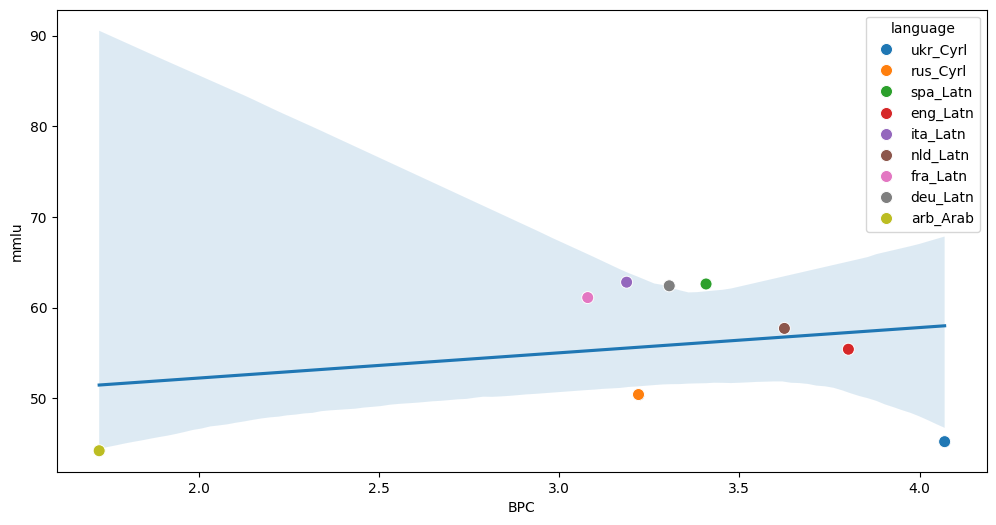

In [59]:
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.regplot(bpc_results, x="BPC", y="mmlu")
sns.scatterplot(
    data=bpc_results, x="BPC", y="mmlu", hue="language", marker='o', s=75
)
plt.savefig('results/phi35-mmlu-BPC.png')

In [1]:
import pandas as pd

bpc_results = pd.read_csv('results/BPC_phi35.csv')

In [3]:
bpc_results = bpc_results.drop([3])

In [5]:
bpc_results

,Unnamed: 0,language,total bits,total characters,BPC,total loss,mmlu,mean_id
0,0,ukr_Cyrl,NaN,54006,4.069608,152342.128082,45.2,30.605666
1,1,rus_Cyrl,NaN,51726,3.220181,115455.501617,50.4,30.338926
2,2,spa_Latn,NaN,45162,3.407555,106669.815155,62.6,29.884499
4,4,ita_Latn,NaN,46294,3.187171,102271.702362,62.8,28.871923
5,5,nld_Latn,NaN,45784,3.625004,115039.671783,57.7,29.129587
6,6,fra_Latn,NaN,45834,3.079266,97827.374969,61.1,28.831754
7,7,deu_Latn,NaN,43930,3.305470,100651.418976,62.4,28.842257
8,8,arb_Arab,NaN,108306,1.723676,129399.791779,44.2,28.842255


In [7]:
from scipy import stats
res = stats.spearmanr(bpc_results['BPC'], bpc_results['mmlu'])
res.statistic

0.023809523809523815

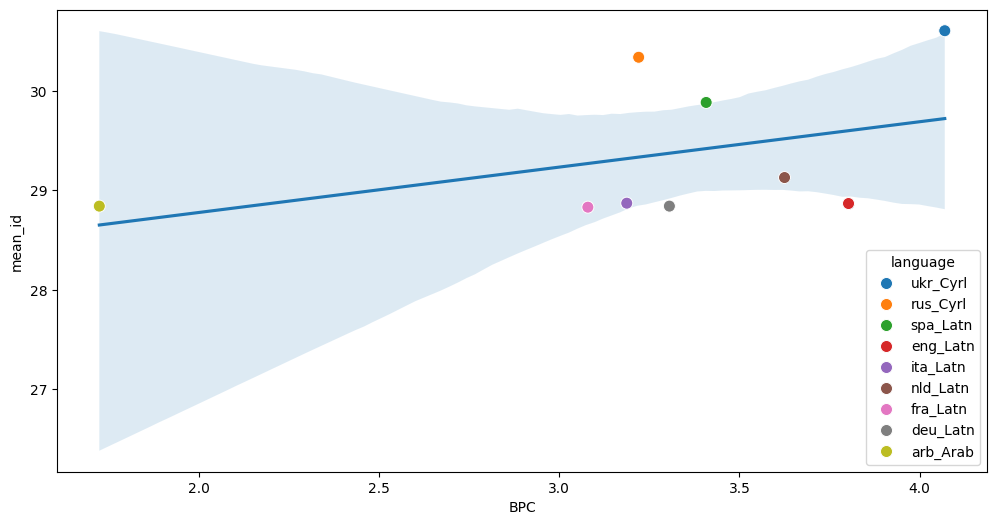

In [60]:
plt.figure(figsize=(12,6))
sns.regplot(bpc_results, x="BPC", y="mean_id")
sns.scatterplot(
    data=bpc_results, x="BPC", y="mean_id", hue="language", marker='o', s=75
)
plt.savefig('results/phi35-id-BPC.png')

In [8]:
res = stats.spearmanr(bpc_results['BPC'], bpc_results['mean_id'])
res.statistic

0.7619047619047621